## HIV-1 ENV energy landscape
* Analysis of HIV-1 protease encoding region from genome of longitudinal patient samples
* Data obtained from Kearney CTL paper (pdf in directory


In [1]:
import os.path, sys
# Define path to utility code and insert it into jupyter path for import
path_to_utilities = '/data/cresswellclayec/ER_omic/utilities/'
sys.path.insert(0, path_to_utilities)

import numpy as np
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from joblib import Parallel, delayed
import timeit
# %matplotlib inline

import matplotlib.pyplot as plt

# # --- Import our Code ---# #
#import emachine as EM
from direct_info import direct_info
# # codon mapping -- get protein sequence from nucleotide sequence
from codon_mapping import translate_sequence
# import data processing and general DCA_ER tools
from data_processing import data_processing_msa2pdb
import tools
from pathlib import Path
np.random.seed(1)

from Bio import SeqIO
from Bio.PDB import *
from scipy.spatial import distance_matrix
from Bio import pairwise2
#from Bio.SubsMat.MatrixInfo import blosum62
pdb_parser = Bio.PDB.PDBParser()

from prody import *
import pickle


Exception ignored in: <_io.FileIO name='/gpfs/gsfs8/users/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/Align/substitution_matrices/data/BENNER22' mode='rb' closefd=True>
Traceback (most recent call last):
  File "/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/Align/substitution_matrices/__init__.py", line 513, in load
    matrix = read(path)
Exception ignored in: <_io.FileIO name='/gpfs/gsfs8/users/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/Align/substitution_matrices/data/BENNER6' mode='rb' closefd=True>
Traceback (most recent call last):
  File "/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/Align/substitution_matrices/__init__.py", line 513, in load
    matrix = read(path)
Exception ignored in: <_io.FileIO name='/gpfs/gsfs8/users/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/Align/substitution_matrices/data/BENNER74' mode='rb' closefd=True>
Traceback (most recent call la

Exception ignored in: <_io.FileIO name='/gpfs/gsfs8/users/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/Align/substitution_matrices/data/JONES' mode='rb' closefd=True>
Traceback (most recent call last):
  File "/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/Align/substitution_matrices/__init__.py", line 513, in load
    matrix = read(path)
Exception ignored in: <_io.FileIO name='/gpfs/gsfs8/users/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/Align/substitution_matrices/data/LEVIN' mode='rb' closefd=True>
Traceback (most recent call last):
  File "/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/Align/substitution_matrices/__init__.py", line 513, in load
    matrix = read(path)
Exception ignored in: <_io.FileIO name='/gpfs/gsfs8/users/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/Align/substitution_matrices/data/MCLACHLAN' mode='rb' closefd=True>
Traceback (most recent call last):

In [2]:
# Define data directories
hiv_dir = '/data/cresswellclayec/ER_omic/energy_landscape/hiv'
data_dir = "%s/data/kearney" % hiv_dir

In [46]:
# Consensus amino acid sequence (from - ):
consensus = 'PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKMIGGIGGFIKVRQYDQILIEICGHKAIGTVLVGPTPVNIIGRNLLTQIGCTLNF'


# Load all Kearney CTL-paper sequences (protease)

# Which Protein data do we load?
# protein_code = 'e'
protein_code = 'p'

# Patient codes
ctl_patient_numbers = [1001, 1002, 1003, 1004, 1005, 3021, 3024, 
                       3036, 3037, 3041, 3062, 3077, 3088]

# Load the patient data for the given protein
patient_seqs_genome = [] # list of rna sequences per patient
patient_seqs_prot = []  # list of protein sequences per patient
patient_codon_map = []   # list of codon mapping from rna to protein sequences per patient
for pat_num in ctl_patient_numbers:
    seq_set = []
    with open('%s/%d/%d%s_edit.fas' % (data_dir, pat_num,pat_num,protein_code), 'rU') as f:
        seq_iter = SeqIO.parse(f,'fasta')
        for seq in seq_iter:
            seq_set.append(seq)

    # Get numpy array of rna sequences and add it to patient list
    s0 = np.array([seq.seq for seq in seq_set])
    patient_seqs_genome.append(s0)
    print('patient %d %s-protein alignment: ' % (pat_num, protein_code), s0.shape)
    
    
    # get numpy array of protein sequences and add it to patient list
    # -- there is an issue here because the aligned sequences have gaps,
    #    these gaps are removed and the resulting protein sequences must then be re-aligned
    #    this process requires a consensus sequence so for now we won't do it.
    if 0:
        seqs_prot = []
        codon_map = []
        indices = np.array([i for i in range(s0.shape[1])])
        for seq in s0:
            protein, index_mapping = translate_sequence(seq,indices)
            seqs_prot.append(np.array(protein))
        patient_seqs_prot.append( np.array(seqs_prot))


patient 1001 p-protein alignment:  (124, 1320)
patient 1002 p-protein alignment:  (163, 1193)
patient 1003 p-protein alignment:  (278, 1155)
patient 1004 p-protein alignment:  (193, 1165)
patient 1005 p-protein alignment:  (164, 1208)
patient 3021 p-protein alignment:  (156, 1159)
patient 3024 p-protein alignment:  (132, 1190)
patient 3036 p-protein alignment:  (86, 1416)
patient 3037 p-protein alignment:  (127, 1114)
patient 3041 p-protein alignment:  (136, 1231)
patient 3062 p-protein alignment:  (142, 1140)
patient 3077 p-protein alignment:  (116, 1114)
patient 3088 p-protein alignment:  (107, 1137)


In [15]:
# patient 1003 and 1005 show population diversity.
# patient 1003 has more sequences so lets consider them.
s0 = patient_seqs_genome[2]
pat_num = ctl_patient_numbers[2]

# Get one-hot encoding of all posible sequences
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
onehot_encoder.fit(s0)
s = onehot_encoder.transform(s0)

In [36]:
# Get PCA reduction of one-hot data in order to visualize as in the paper
from sklearn.decomposition import PCA
pca_dim=3
pca = PCA(n_components = pca_dim)
pca_s = pca.fit_transform(s)


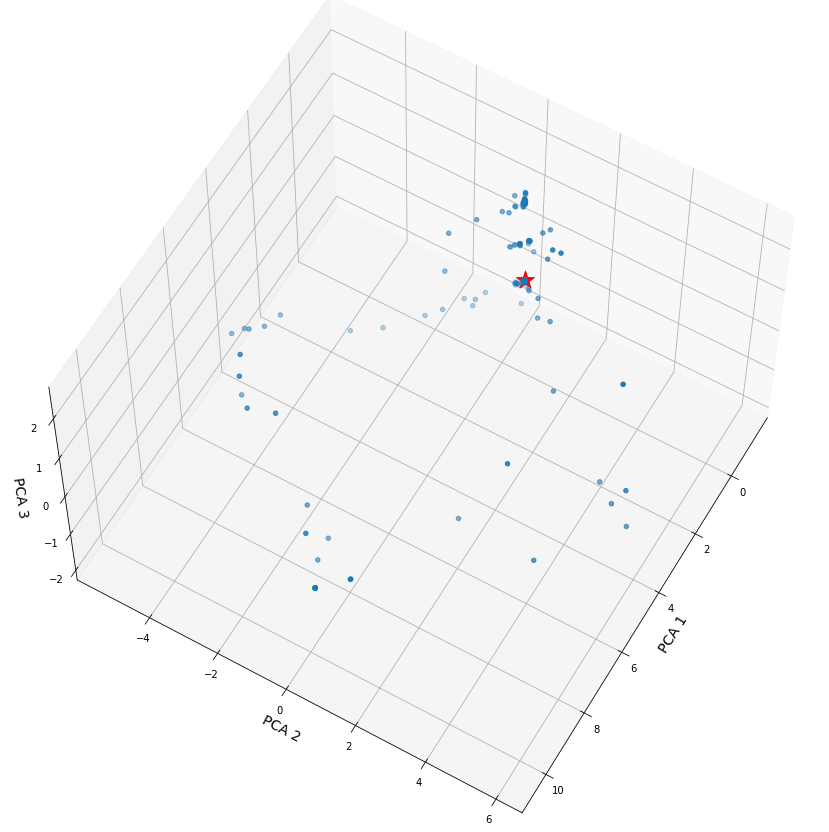

In [45]:
# Plot PCA and visualize evolution/transition of families
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

ax.scatter(pca_s[:,0], pca_s[:,1], pca_s[:,2])
ax.scatter(pca_s[0,0], pca_s[0,1], pca_s[0,2], s=350, marker='*', c='r')
ax.set_xlabel('PCA 1', fontsize=14)
ax.set_ylabel('PCA 2', fontsize=14)
ax.set_zlabel('PCA 3', fontsize=14)
ax.view_init(60,30)
plt.show()

## Generate w_ER
* Use expectation reflection to infer co-evolutionary relationship between sequence positions

In [13]:
# number of positions
n_var = s0.shape[1]
n_seq = s0.shape[0]

print("Number of nucleotide positions:",n_var)
print("Number of sequences:",n_seq)

# number of aminoacids at each position
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])
print("Number of different nucleotides at each position",mx)

# total number of onehot variables
mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T
# print(\"(Sanity Check) Column indices of first and (\",i1i2[0],\") and last (\",i1i2[-1],\") positions\")
# print(\"(Sanity Check) Column indices of second and (\",i1i2[1],\") and second to last (\",i1i2[-2],\") positions\")

# number of variables
mx_sum = mx.sum()
print("Total number of variables",mx_sum)

# number of bias term
n_linear = mx_sum - n_var

Number of nucleotide positions: 1155
Number of sequences: 278
Number of different nucleotides at each position [2 3 1 ... 1 1 1]
Total number of variables 1420


In [16]:
from joblib import Parallel, delayed                                                                     
import expectation_reflection as ER                                                                      
s_centered = s - s.mean(axis=0)      
s_train = s

print(s_train.shape)
# Define w matrix with variable for each possible nucleotide at each sequence position               
w_ER = np.zeros((mx.sum(),mx.sum()))                                                                     
h0 = np.zeros(mx.sum())             

# Expectation Reflection                                                                                 
#=========================================================================================#
def predict_w(s,i0,i1i2,niter_max,l2):                                                                   
    #print('i0:',i0)                                                                                     
    i1,i2 = i1i2[i0,0],i1i2[i0,1]                                                                        
    x = np.hstack([s[:,:i1],s[:,i2:]])                                                                   
    y = s[:,i1:i2]                                                                                       
    h01,w1 = ER.fit(x,y,niter_max,l2)                                                                    
    return h01,w1                                                                                        


w_file = "%s/%d%s_w.npy" % (data_dir, pat_num, protein_code)   
wsym_file = "%s/%d%s_w_sym.npy" % (data_dir, pat_num, protein_code)   
b_file = "%s/%s%s_b.npy" % (data_dir, pat_num, protein_code)        

create_new = False
if os.path.exists(w_file) and not create_new:                                                          
    w_ER = np.load(w_file)      
    w_ER_sym = np.load(w_file)                                                                               
    b = np.load(b_file)                                                                               

else:                                                                                                    
    #-------------------------------                                                                     
    # parallel                                                                                           
    start_time = timeit.default_timer()                                                                  
    res = Parallel(n_jobs = 20-2)(delayed(predict_w)                                                   
            (s_train,i0,i1i2,niter_max=10,l2=100.0)                                                          
            for i0 in range(n_var))

    run_time = timeit.default_timer() - start_time                                                       
    print('run time:',run_time)                                                                          
    #------------------------------- 
    for i0 in range(n_var):
        i1,i2 = i1i2[i0,0],i1i2[i0,1]                                                                    

        h01 = res[i0][0]                                                                                 
        w1 = res[i0][1]

        h0[i1:i2] = h01                                                                                  
        w_ER[:i1,i1:i2] = w1[:i1,:]                                                                      
        w_ER[i2:,i1:i2] = w1[i1:,:]                                                                      

    # make w symmetric                                                                                   
    w_ER_sym = (w_ER + w_ER.T)/2.            
    print(w_ER)
    print(w_ER_sym)
    b = h0

    np.save(w_file, w_ER)
    np.save(wsym_file, w_ER_sym)
    np.save(b_file, b)


(278, 1420)
run time: 147.88918745238334
[[ 0.00000000e+00  0.00000000e+00 -4.36387695e-02 ...  5.01239830e-07
   1.62341270e-07 -3.39761406e-06]
 [ 0.00000000e+00  0.00000000e+00  4.36387695e-02 ... -5.01239830e-07
  -1.62341270e-07  3.39761406e-06]
 [-6.29679123e-02  6.28337788e-02  0.00000000e+00 ...  1.43221004e-05
  -1.01951928e-05 -1.01169528e-04]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
[[ 0.00000000e+00  0.00000000e+00 -5.33033409e-02 ...  2.50619915e-07
   8.11706352e-08 -1.69880703e-06]
 [ 0.00000000e+00  0.00000000e+00  5.32362742e-02 ... -2.50619915e-07
  -8.11706352e-08  1.69880703e-06]
 [-5.33033409e-02  5.32362742e-02  0.00000000e+00 ...  7.16105019e-06
  -5.09759638e-06 -5.05847638e-05]
 ...
 [ 

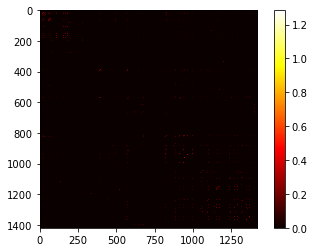

In [21]:
fig, ax = plt.subplots()
# abs so that we can see the coupled/anticoupled
c = ax.imshow(abs(w_ER), cmap='hot', interpolation='nearest')
fig.colorbar(c, ax=ax)
plt.show()

In [28]:
from er_energy import energy_diff
from scipy.spatial import distance



print('identity energy difference: ', energy_diff(i1i2,s_train[0,:], s_train[0,:], w_ER, b, return_pos_array=True))
print('seq 1 vs 2 energy difference: ', energy_diff(i1i2,s_train[0,:],s_train[2,:],w_ER, b))
print('seq 1 vs last energy difference: ', energy_diff(i1i2,s_train[0,:],s_train[-1,:],w_ER, b))

print('seq 1 vs seq2 hamming distance: ', distance.squareform(distance.pdist(s_train[0:2,:], 'hamming')))
print(distance.squareform(distance.pdist([s_train[1,:],s_train[2,:]], 'hamming'))[0][1])

identity energy difference:  (1092.543726756484, array([3.93651697, 3.9321012 , 4.27689672, ..., 4.37931631, 4.3796417 ,
       4.39579733]))
seq 1 vs 2 energy difference:  1094.8954872581317
seq 1 vs last energy difference:  1099.8295950635556
seq 1 vs seq2 hamming distance:  [[0.        0.0028169]
 [0.0028169 0.       ]]
0.0


In [31]:
# Calulate sequence energy of all sequences from the perspective of different 
# "sequence backgrounds"
if not os.path.exists('%s/%d%s_energy.npy' % (data_dir,pat_num,protein_code)):
        s_E_row = np.zeros(len(s))
        print(energy_diff(i1i2,s[0,:], s[1,:],w_ER, b))

        res = Parallel(n_jobs = 20-2)(delayed(energy_diff)
                (i1i2,s[0,:],s[i0,:],w_ER,b)
                for i0 in range(len(s)))
        s_E_row = np.array(res)
        print(s_E_row.shape)
        np.save('%s/%d%s_energy.npy' % (data_dir,pat_num,protein_code), s_E_row)
else:
    s_E_rows = []
    for i in range(len(gps)):
        s_E_row= np.load('%s/%d%s_energy.npy' % (data_dir, pat_num,protein_code))


1094.8954872581317
(278,)


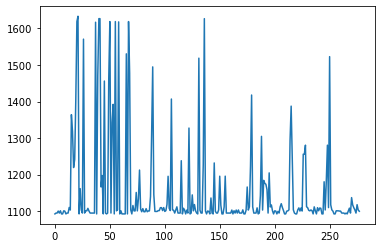

In [33]:
plt.plot(s_E_row)
plt.show()

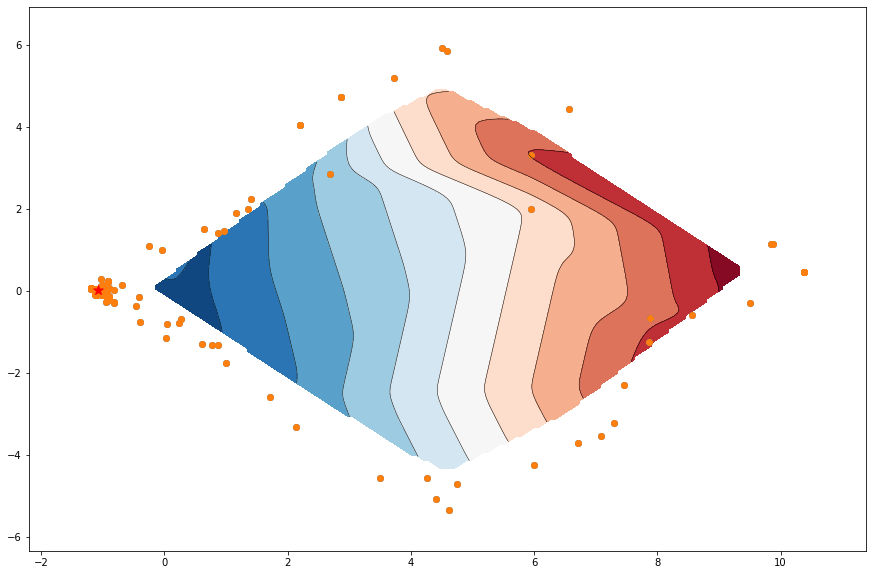

In [39]:
from scipy.ndimage.filters import gaussian_filter
import matplotlib.tri as tri                                                                                                     

x = pca_s[:, 0]
y = pca_s[:, 1]
z = s_E_row

fig = plt.figure(figsize=(15,10))
ax  = fig.add_subplot(111)

# Create grid values first.
ngridx = 200
ngridy = 200
xi = np.linspace(min(x)-1, max(x)+1, ngridx)
yi = np.linspace(min(y)-1, max(y)+1, ngridy)

# Perform linear interpolation of the data (x,y)
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)

Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)
Zi = gaussian_filter(zi, sigma=2.)

ax.contour(Xi, Yi, Zi, levels=10, linewidths=0.5, colors='k')
cntr1 = ax.contourf(Xi, Yi, Zi, levels=10, cmap="RdBu_r")
                                                                              

ax.scatter(pca_s[:,0], pca_s[:,1])  
ax.scatter(pca_s[:,0], pca_s[:,1])                                                                               

ax.scatter(pca_s[0,0], pca_s[0,1], marker='*',c='r',s=100)
plt.show()